In [1]:
from karabo.imaging.imager import Imager
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import (
    PyBDSFSourceDetectionResult,
)
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation
import matplotlib.pyplot as plt
from datetime import datetime

# Render plots inline
%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


## Simulation

/home/lukas/i4ds/ska/Karabo-Pipeline/karabo/simulation/sky_model.py:830: KaraboWarning: Warning: flux with value <= 0 found, setting those to np.nan to avoid logarithmic errors (only affects the colorbar)
  warn(


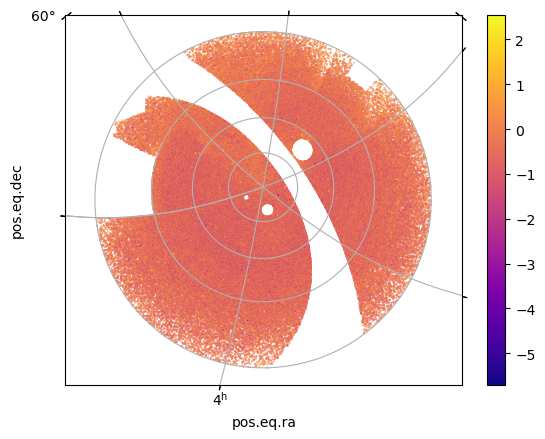

In [2]:
# Get GLEAM Survey Sky
phase_center = [250, -80]
gleam_sky = SkyModel.get_GLEAM_Sky([76])
gleam_sky.explore_sky(phase_center, s=0.1)

Then we filter the sky model based on radius.

In [3]:
sky = gleam_sky.filter_by_radius(0, 0.55, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 250.0  -80.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

Let's have a closer look with the 2d image project explore_sky() provides.

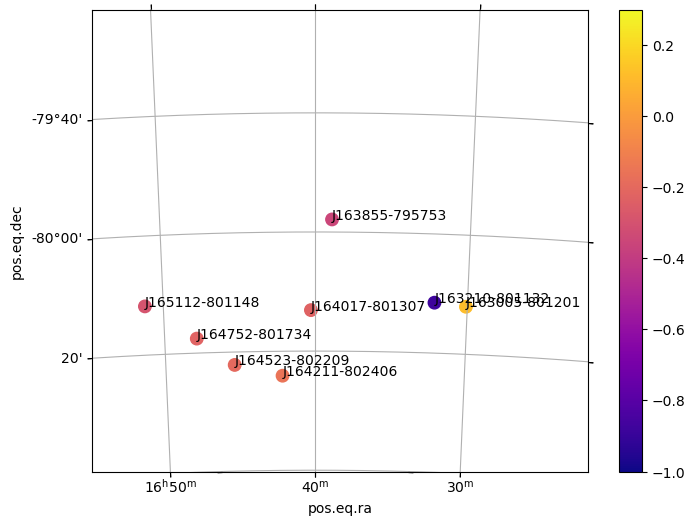

In [4]:
sky.explore_sky(
    phase_center=phase_center,
    figsize=(8, 6),
    xlim=(254, 246),  # RA-lim
    ylim=(-81, -79),  # DEC-lim
    with_labels=True,
    s=80,
    vmin=-1,
    vmax=0.3,
)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

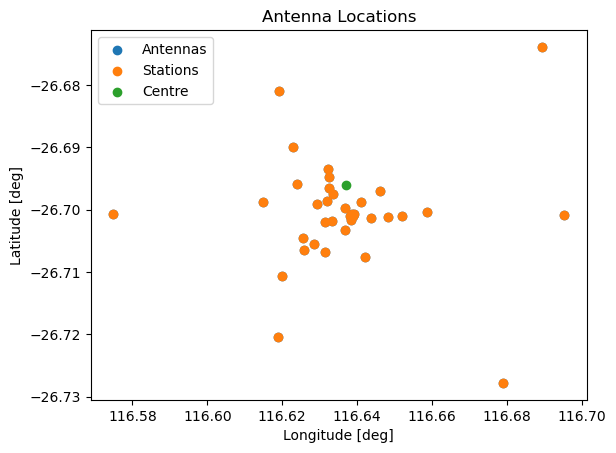

In [5]:
askap_tel = Telescope.constructor("ASKAP")
askap_tel.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [6]:
from karabo.simulation.visibility import Visibility

observation_settings = Observation(
    start_frequency_hz=100e6,
    start_date_and_time=datetime(2024, 3, 15, 10, 46, 0),
    phase_centre_ra_deg=phase_center[0],
    phase_centre_dec_deg=phase_center[1],
    number_of_channels=16,
    number_of_time_steps=24,
)

# If you want, you can define where karabo should store the visibilities
# If not, karabo will decide where to store it.
vis = Visibility()
vis_path = vis.vis_path

print(f"Saving file to {vis_path}")
interferometer_sim = InterferometerSimulation(
    vis_path=vis_path, channel_bandwidth_hz=1e6
)
visibility_askap = interferometer_sim.run_simulation(
    askap_tel,
    sky,
    observation_settings,
)

Creating /tmp/karabo-STM-lukas-hiDOQLUxGv/visibility-3CdK1Usizk for visibility disk-cache
Saving file to /tmp/karabo-STM-lukas-hiDOQLUxGv/visibility-3CdK1Usizk/visibility.vis
Parameter 'use_gpus' is None! Using function 'karabo.util.is_cuda_available()'. To overwrite, set 'use_gpu' True or False.
Creating /tmp/karabo-STM-lukas-hiDOQLUxGv/interferometer-zuEths6KhD for interferometer disk-cache.
W|                                                                   
W|== WARNING: Gaussian ellipse solution failed for 8 sources. These will be simulated as point sources.
W|                                                                   
Saved visibility to /tmp/karabo-STM-lukas-hiDOQLUxGv/visibility-3CdK1Usizk/visibility.vis


### Dirty Images

We can create dirty images of visibilites and display them as shown below

In [7]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

Creating /tmp/karabo-STM-lukas-hiDOQLUxGv/Imager-Dirty-a706YVAVuM for disk-cache for dirty.fits


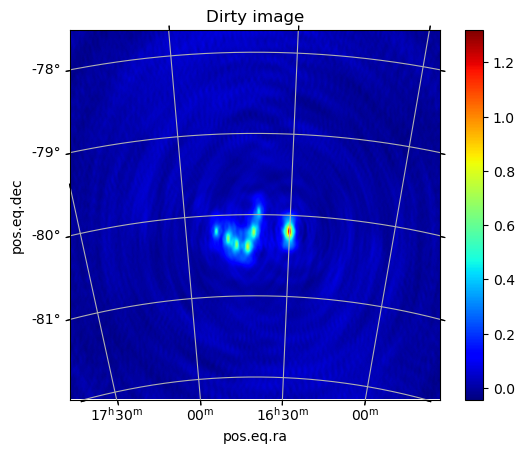

In [8]:
imager_askap = Imager(
    visibility_askap,
    imaging_npixel=imaging_npixel,
    imaging_cellsize=imaging_cellsize,
)
dirty = imager_askap.get_dirty_image()
dirty.plot(title="Dirty image")

### Source Detection

In [9]:
detection_result_dirty = PyBDSFSourceDetectionResult.detect_sources_in_image(
    image=dirty,
    thresh_isl=15,
    thresh_pix=20,
)

/home/lukas/i4ds/ska/Karabo-Pipeline/karabo/sourcedetection/result.py:170: KaraboWarning: No beam parameter provided by `beam` or found in image header. guessing parameters using `Imager.guess_beam_parameters`.
  warn(
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Creating /tmp/karabo-STM-lukas-hiDOQLUxGv/pybdsf-sdr-R0Q04ql3Wk for pybdsf source-detection-result disk-cache
--> Wrote ASCII file '/tmp/karabo-STM-lukas-hiDOQLUxGv/pybdsf-sdr-R0Q04ql3Wk/sources.csv'
--> Wrote file '/tmp/karabo-STM-lukas-hiDOQLUxGv/pybdsf-sdr-R0Q04ql3Wk/ch0-result.fits'


In [10]:
ground_truth, sky_idxs = Imager.project_sky_to_image(
    sky=sky,
    phase_center=phase_center,
    imaging_cellsize=imaging_cellsize,
    imaging_npixel=imaging_npixel,
    filter_outlier=True,
    invert_ra=True,
)

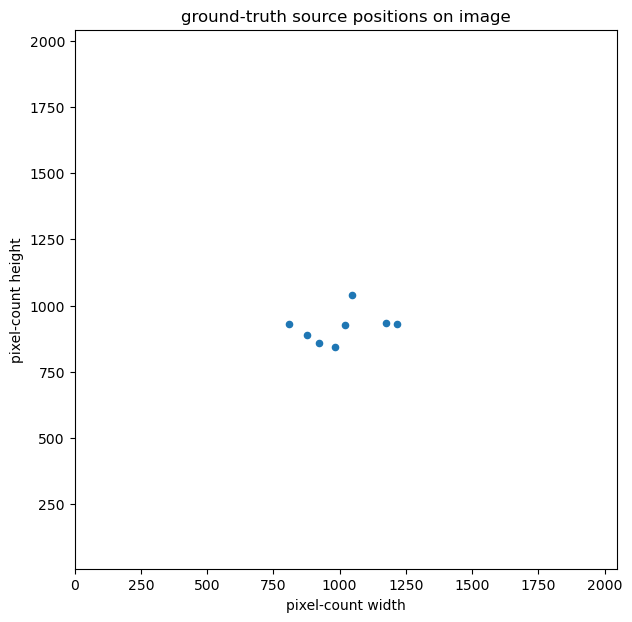

In [11]:
fig, ax = plt.subplots(
    figsize=(7, 7),
)
sc = ax.scatter(ground_truth[0], ground_truth[1], s=20)

# for idx, i in enumerate(range(ground_truth[0].shape[0])):
#     ax.annotate(sky[idx,-1], (ground_truth[0][i], ground_truth[1][i]))

plt.axis("equal")
plt.title("ground-truth source positions on image")
plt.xlim((0, imaging_npixel))
plt.ylim((0, imaging_npixel))
plt.xlabel("pixel-count width")
plt.ylabel("pixel-count height")
plt.show()

In [12]:
assignments_dirty = (
    SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
        ground_truth=ground_truth.T,
        detected=detection_result_dirty.get_pixel_position_of_sources(),
        max_dist=10,
        top_k=3,
    )
)
assignments_dirty

array([[-1.        ,  3.        ,         inf],
       [ 0.        ,  0.        ,  1.67680721],
       [ 1.        , -1.        ,         inf],
       [ 2.        , -1.        ,         inf],
       [ 3.        ,  2.        ,  3.05090692],
       [ 4.        ,  1.        ,  4.61629504],
       [ 5.        , -1.        ,         inf],
       [ 6.        , -1.        ,         inf],
       [ 7.        , -1.        ,         inf]])

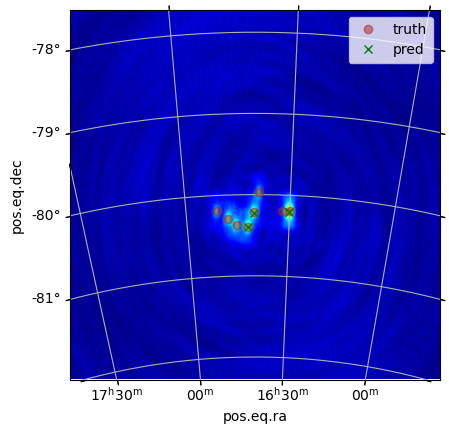

In [13]:
sde_dirty = SourceDetectionEvaluation(
    sky=sky,
    ground_truth=ground_truth,
    assignments=assignments_dirty,
    sky_idxs=sky_idxs,
    source_detection=detection_result_dirty,
)
sde_dirty.plot()

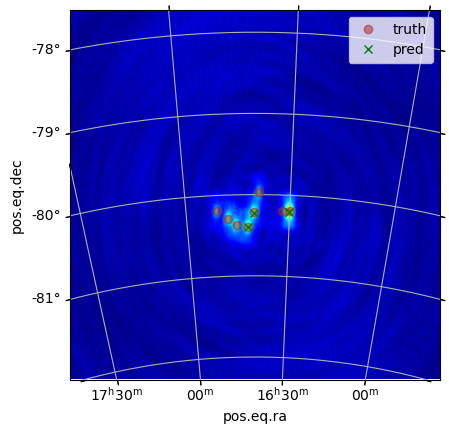

In [14]:
sde_dirty = SourceDetectionEvaluation(
    sky=sky,
    ground_truth=ground_truth,
    assignments=assignments_dirty,
    sky_idxs=sky_idxs,
    source_detection=detection_result_dirty,
)
sde_dirty.plot()

### Imaging
Of course, we can also do source detection on cleaned (clean algorithmus by rascil) images.

In [15]:
imager_askap.ingest_chan_per_vis = 1
imager_askap.ingest_vis_nchan = 16

# Try differnet algorithm
# More sources
deconvolved, restored, residual = imager_askap.imaging_rascil(
    clean_nmajor=1,
    clean_algorithm="mmclean",
    clean_scales=[10, 30, 60],
    clean_fractional_threshold=0.3,
    clean_threshold=0.12e-3,
    clean_nmoment=5,
    clean_psf_support=640,
    clean_restored_output="integrated",
    use_dask=True,
)

Creating /tmp/karabo-STM-lukas-hiDOQLUxGv/Imaging-Rascil-Pr9lbkzKz3 for disk-cache for non-specified .fits files.
Dashboard link: http://10.223.9.120:8787/status
LocalCluster(b7053bab, 'inproc://10.223.9.120/64042/1', workers=1, threads=12, memory=31.00 GiB)


## Analysis via Source Detection

Source Detection on restored image.

In [16]:
import numpy as np

dirty.get_cellsize() * np.sqrt(8.0 * np.log(2.0))

9.133191795055732e-05

In [17]:
detection_result = PyBDSFSourceDetectionResult.detect_sources_in_image(
    restored, thresh_isl=15, thresh_pix=20
)

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Creating /tmp/karabo-STM-lukas-hiDOQLUxGv/pybdsf-sdr-jLdN7m4xs2 for pybdsf source-detection-result disk-cache
--> Wrote ASCII file '/tmp/karabo-STM-lukas-hiDOQLUxGv/pybdsf-sdr-jLdN7m4xs2/sources.csv'
--> Wrote file '/tmp/karabo-STM-lukas-hiDOQLUxGv/pybdsf-sdr-jLdN7m4xs2/ch0-result.fits'


## Evaluation

In [18]:
assignments_restored = (
    SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
        ground_truth=ground_truth.T,
        detected=detection_result.get_pixel_position_of_sources(),
        max_dist=15,
        top_k=10,
    )
)
assignments_restored

array([[-1.        ,  6.        ,         inf],
       [ 0.        ,  1.        ,  0.66014019],
       [ 1.        ,  3.        ,  2.28414258],
       [ 2.        ,  4.        ,  0.81915812],
       [ 3.        ,  7.        ,  1.2671306 ],
       [ 4.        ,  2.        ,  1.64610121],
       [ 5.        , -1.        ,         inf],
       [ 6.        ,  0.        ,  1.01761457],
       [ 7.        ,  5.        ,  5.85303669]])

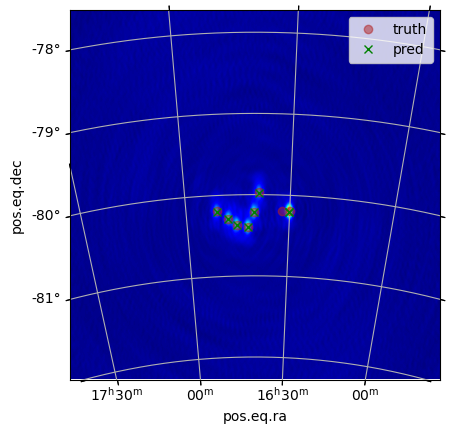

In [19]:
# Create mapping plots
sde_restored = SourceDetectionEvaluation(
    sky=sky,
    ground_truth=ground_truth,
    assignments=assignments_restored,
    sky_idxs=sky_idxs,
    source_detection=detection_result,
)
sde_restored.plot()

In [20]:
# Confusion Matrix
sde_restored.get_confusion_matrix()

array([[0., 1.],
       [1., 7.]])

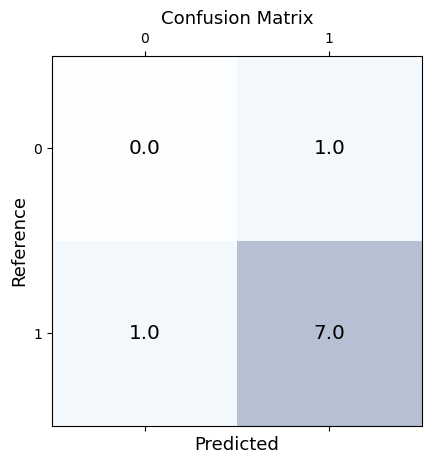

In [21]:
sde_restored.plot_confusion_matrix()

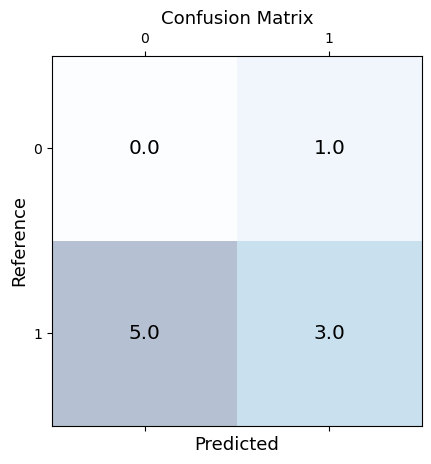

In [22]:
sde_dirty.plot_confusion_matrix()

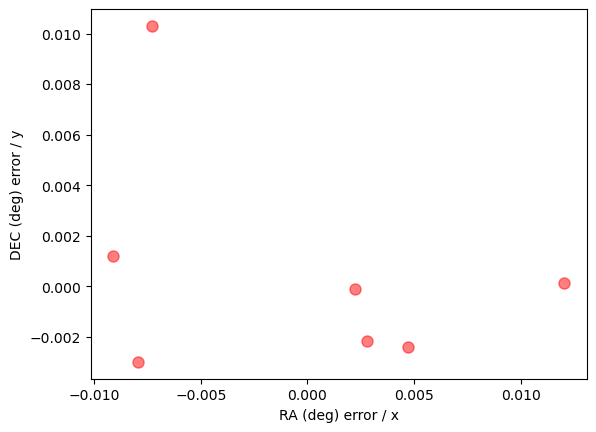

In [23]:
# Plot error ra and dec
sde_restored.plot_error_ra_dec()

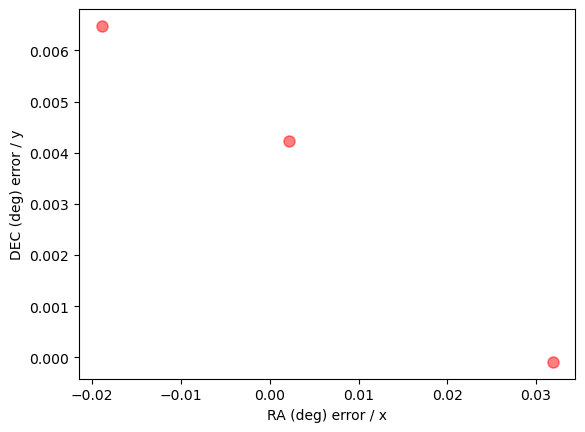

In [24]:
# Plot error ra and dec
sde_dirty.plot_error_ra_dec()

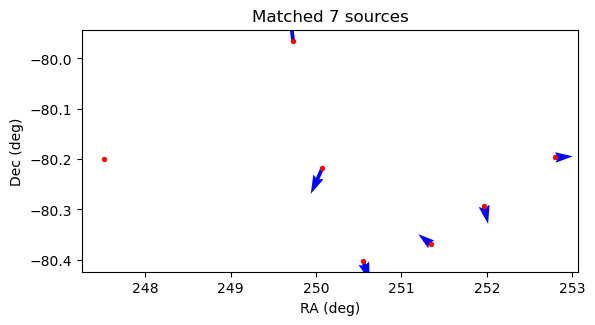

In [25]:
# Plot error flux
sde_restored.plot_quiver_positions()

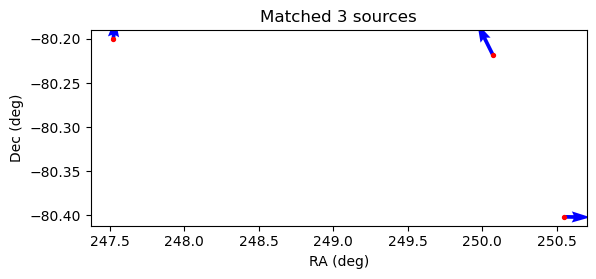

In [26]:
# Plot error flux
sde_dirty.plot_quiver_positions()

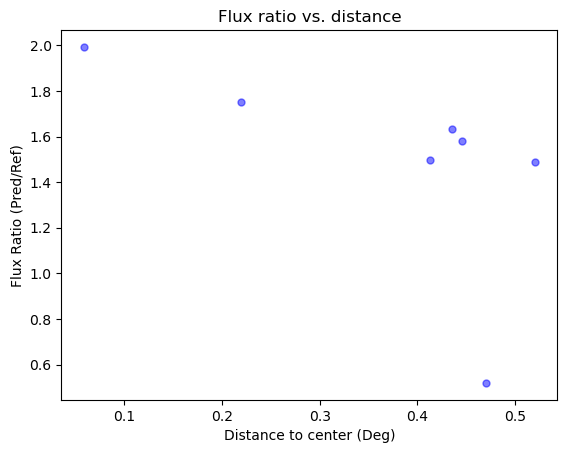

In [27]:
# Plot error ra and dec
sde_restored.plot_flux_ratio_to_distance()

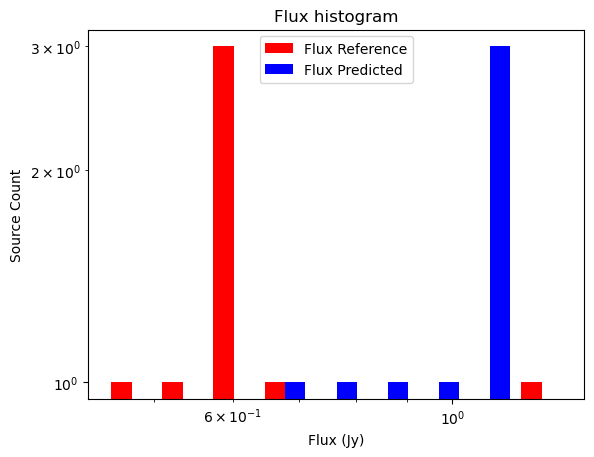

In [28]:
# Plot error ra and dec
sde_restored.plot_flux_histogram()

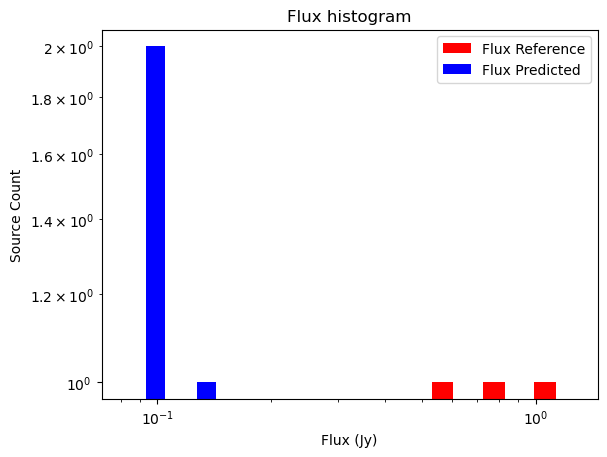

In [29]:
# Plot error ra and dec
sde_dirty.plot_flux_histogram()

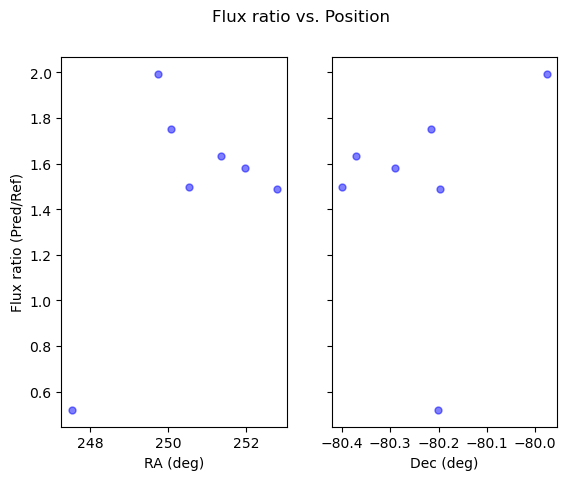

In [30]:
# Plot error ra and dec
sde_restored.plot_flux_ratio_to_ra_dec()

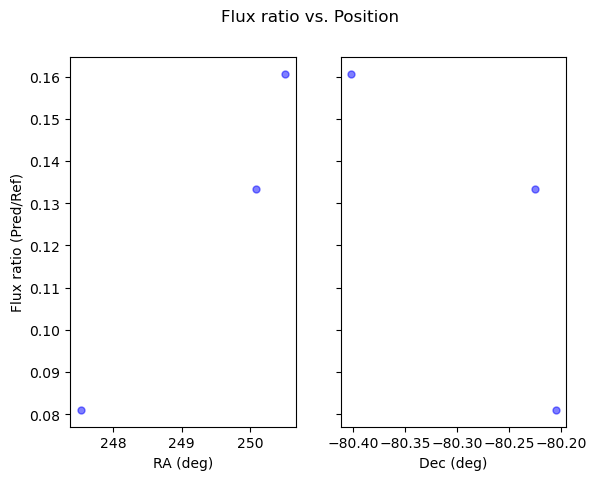

In [31]:
# Plot error ra and dec
sde_dirty.plot_flux_ratio_to_ra_dec()